# Introduction to StochSS-Compute
  
If you have ever used Gillespy2 to run simulations locally, you should not have too much difficulty running remote simulations, as the syntax is nearly the same. Running a simulation remotely with GillesPy2 requires 3 components: a `Model()` (your data), a `Solver()` (SSA, TauHybrid, ODE, etc.), and a running instance of a `ComputeServer()`. If you do not wish to explicitly state the solver, one will be automatically chosen.

In [1]:
import sys, os
import numpy
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
import gillespy2
from stochss_compute import RemoteSimulation, ComputeServer

### Creating a GillesPy2 Model  
  
A GillesPy2 model must include species, rates, and reactions.

In [2]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            ''' 
            PARAMETERS:
            These are constant values relevant to the system, such as reaction kinetic rates.
            
            name: user defined name for reference
            expression: constant value
            '''
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.0017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.51)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.11)
            
            # Add parameters to the model
            self.add_parameter([rate1,rate2,rate3])
            
            '''
            SPECIES:
            These can be anything that participates in or is produced by a reaction channel.
            
            name: A user defined name for the species
            initial_value: value/population count of species at start of simulation
            '''
            A = gillespy2.Species(name='A', initial_value=301)
            B = gillespy2.Species(name='B', initial_value=121)
            C = gillespy2.Species(name='C', initial_value=0)
            D = gillespy2.Species(name='D', initial_value=0)
            
            # Add species to the model
            self.add_species([A, B, C, D])
            
            '''Reactions:
            These are the reaction channels causing the system to change over time
            
            name: a user defined name for the reaction
            reactants: dictionary with participant reactants as keys, and consumed per reaction as value.
            products: dictionary with reaction products as keys, and number formed per reaction as value.
            rate: parameter rate constant to be applied to the propensity of this reaction firing
            propensity_function: can be used instead of rate in order to declare a custom propensity function in string format'''
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            
            # Add reactions to the model
            self.add_reaction([r1,r2,r3])
            
            # Set timespan of model
            self.timespan(numpy.linspace(0,100,101))

### Running Simulations and Plotting

First, instantiate a `Model()`. Next, instantiate a `ComputeServer()` that points to your running instance of StochSS-Compute. After you call `run()`, which returns your future `RemoteResults`, you will have to wait for the simulation to finish. Calling `wait()`, `status()`, `resolve()`, or `cancel()` allows you to interact with your results. Call `resolve()` to wait for the simulation to finish and fetch the results. Continue reading for more details on the various parameters that you may set.

[ModelRunRequest] http://172.17.0.2:29681/api/v1/gillespy2/model/run
[GET] http://172.17.0.2:29681/api/v1/job/ce0d5b3af0d5ec38e1d3892536f9ef78-run_1/status
The job is complete.
4
[GET] http://172.17.0.2:29681/api/v1/memory/ce0d5b3af0d5ec38e1d3892536f9ef78-run_1/get
Results size: 2147
Expanded to: 37047


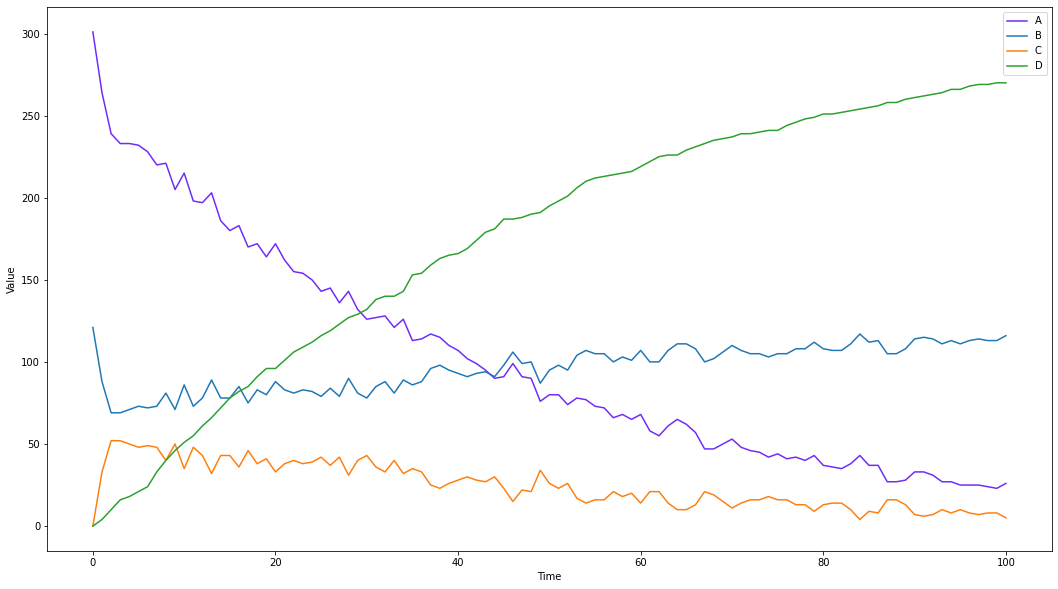

In [7]:
myModel = MichaelisMenten()

myServer = ComputeServer("localhost", port=29681)

In [ ]:
remoteResults = RemoteSimulation.on(myServer).with_model(myModel).run()

results = remoteResults.resolve()

In [ ]:
results.plot()

In [6]:
print(results)

AttributeError: 'RemoteResults' object has no attribute 'data'

#### 7. Options
#### Model.run() keyword arguments
While the model.run() function can be called without any given arguments, GillesPy2 provides several options for customizing your simulations. The following keyword arguments can be used in the model.run() function to customize your simulations:  

**algorithm=None**  
    [str]: Manually choose an algorithm from one of the following GillesPy2 solvers:  
    "ODE"  
    "Tau-Hybrid"    
    "Tau-Leaping"    
    "SSA"    
    
**number_of_trajectories=1**  
    [int]: Number of times to run the current simulation.  
    
**seed=None**  
    [int]: Define a custom seed for random number generation.

**show_labels=True**  
    [bool]: When set to true (default) returns results in a dictonary with time and species as dictionary keys, and relevant trajectory vectors as value pair.  When set to False, results will be returned as a numpy array with dimensions [timestep][species_index].  Either way, the the results of each trajectory are stored in a list.

***

#### Results.plot() keyword arguments
**xaxis_label='Time (s)'**  
    [string]: Label for the plot's x-axis.  
    
**yaxis_label='Species Population'**  
    [string]: Label for the plot's y-axis.  

**style='default'**  
    [string]: matplotlib stylesheets https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html.  

**title=None**  
    [string]: Title of figure.  

**show_legend=True**  
    [bool]: Show legend if true.  

**multiple_graphs=False**  
    [bool]: Whether each trajectory should have its own graph or if they should overlap.  

**included_species_list=[]**  
    [list]: A list of strings describing which species to include by species name. By default displays all species.  
    
GillesPy2 also offers built-in offline plotly plotting and statistical data plotting.  [See the documents for more details.](https://gillespy2.readthedocs.io)  
  
***

#### Solver specific keyword arguments
##### ODESolver, TauHybridSolver
**integrator='lsoda'**  
    [String]: Integrator to be used form scipy.integrate.ode. Options include 'vode', 'zvode', 'lsoda', 'dopri5', and 'dop835'.  For more details, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html.  
    
**integrator_options={}**  
    [dictionary]: Contains options to the scipy integrator. For a list of options, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html.  
  
##### TauLeapingSolver, TauHybridSolver
**tau_tol=0.03**  
    [float]:  
Relative error tolerance value for calculating tau_step. Value should be between 0.0 - 1.0.  
  
##### TauHybridSolver
**TauHybridSolver: switch_tol=0.03**  
    [float]:  
Relative error tolerance value for switching between deterministic/stochastic.  Value should be between 0.0 - 1.0. 
<br/><br/>

## Hybrid Solver Examples

Some of the solvers in GillesPy2 provide further options for customizing simulations.  For examples on how to use these advanced features, please see the following links:  

[Hybrid: Using Rate Rules to model continuous species](https://github.com/StochSS/GillesPy2/blob/main/examples/AdvancedFeatures/hybrid_continuous_species.ipynb)  
[Hybrid: Dynamically switching between stochastic and deterministic representations](https://github.com/StochSS/GillesPy2/blob/main/examples/AdvancedFeatures/hybrid_switching_example.ipynb)  